# Import and Install Dependencies

In [73]:
!pip install qbstyles

In [74]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns
from qbstyles import mpl_style
#plt.style.use('cyberpunk')
mpl_style(dark = True)
#sns.set_style('darkgrid')
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skew
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score, accuracy_score, roc_auc_score,f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')
palette1 = ['#90A6B1', '#037d97','#E4591E']
palette2 = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']
palette3 = ['#90A6B1', '#037d97', '#C09741']

/kaggle/input/ccp-challange/sample_submission.csv
/kaggle/input/ccp-challange/train.csv
/kaggle/input/ccp-challange/test.csv


In [75]:
df = pd.read_csv('/kaggle/input/ccp-challange/train.csv').iloc[:,1:]
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,596,jabar,Male,32.0,3.0,150268487.1,2.0,0.0,0.0,6.493161e+07,0
1,623,Jawa Timur,Male,43.0,1.0,0.0,2.0,1.0,1.0,2.274471e+08,0
2,601,Jawa Tengah,Female,44.0,4.0,0.0,2.0,1.0,0.0,9.099373e+07,0
3,506,Jawa Barat,Male,59.0,8.0,185140916.0,2.0,1.0,1.0,2.652056e+08,0
4,560,Jawa Tengah,Female,27.0,NaN,194221253.6,1.0,1.0,1.0,1.781762e+08,0
...,...,...,...,...,...,...,...,...,...,...,...
6995,601,Jawa Timur,Male,32.0,8.0,144525288.7,1.0,1.0,0.0,1.351162e+08,0
6996,625,jawabarat,Male,42.0,6.0,155455542.3,NaN,1.0,0.0,1.451733e+08,0
6997,498,jawatimur,Male,73.0,2.0,264524958.3,2.0,1.0,1.0,2.570142e+08,0
6998,593,Jawa Timur,Female,41.0,6.0,0.0,1.0,1.0,0.0,1.012635e+08,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      7000 non-null   int64  
 1   country           6845 non-null   object 
 2   gender            7000 non-null   object 
 3   age               6759 non-null   float64
 4   tenure            6712 non-null   float64
 5   balance           6883 non-null   float64
 6   products_number   6852 non-null   float64
 7   credit_card       6841 non-null   float64
 8   active_member     6863 non-null   float64
 9   estimated_salary  6855 non-null   float64
 10  churn             7000 non-null   int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 601.7+ KB


### Mapping

disini setelah melakukan observasi terdapat beberapa inkonsistensi padahal makna kata tersebut sama. Disini kita melakukan mapping untuk menciptakan konsistensi data.

In [77]:
df['country'].unique()

array(['jabar', 'Jawa Timur', 'Jawa Tengah', 'Jawa Barat', 'jateng',
       'jawabarat', 'jawatimur', 'jatim', 'jawatengah', nan], dtype=object)

In [78]:
country_mapping = {
    'jabar': 'Jawa Barat',
    'jawabarat': 'Jawa Barat',
    'Jawa Barat': 'Jawa Barat',
    'jateng': 'Jawa Tengah',
    'jawatengah': 'Jawa Tengah',
    'Jawa Tengah': 'Jawa Tengah',
    'jatim': 'Jawa Timur',
    'jawatimur': 'Jawa Timur',
    np.nan: np.nan
}

df['country'] = df['country'].map(country_mapping)

print(df['country'].unique())

['Jawa Barat' nan 'Jawa Tengah' 'Jawa Timur']


In [79]:
df.isna().sum()

credit_score           0
country             2913
gender                 0
age                  241
tenure               288
balance              117
products_number      148
credit_card          159
active_member        137
estimated_salary     145
churn                  0
dtype: int64

# Feature Engineering

Menambah variabel baru 'overbalanced' biar tau risiko churn orang tersebut.
Nah kalo dia overbalanced biasanya pasti surplus dana. cenderung ga churn biasanya.
Tapi kalau dia underbalanced biasanya bisa mengalami kesulitan keuangan, nah risiko churn lebih tinggi. Oleh karena itu variabel ini penting

In [80]:
df['is_overbalanced'] = (df.estimated_salary - df.balance).apply(lambda x: 0 if x >= 0 else 1)
df

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,is_overbalanced
0,596,Jawa Barat,Male,32.0,3.0,150268487.1,2.0,0.0,0.0,6.493161e+07,0,1
1,623,NaN,Male,43.0,1.0,0.0,2.0,1.0,1.0,2.274471e+08,0,0
2,601,Jawa Tengah,Female,44.0,4.0,0.0,2.0,1.0,0.0,9.099373e+07,0,0
3,506,Jawa Barat,Male,59.0,8.0,185140916.0,2.0,1.0,1.0,2.652056e+08,0,0
4,560,Jawa Tengah,Female,27.0,NaN,194221253.6,1.0,1.0,1.0,1.781762e+08,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6995,601,NaN,Male,32.0,8.0,144525288.7,1.0,1.0,0.0,1.351162e+08,0,1
6996,625,Jawa Barat,Male,42.0,6.0,155455542.3,NaN,1.0,0.0,1.451733e+08,0,1
6997,498,Jawa Timur,Male,73.0,2.0,264524958.3,2.0,1.0,1.0,2.570142e+08,0,1
6998,593,NaN,Female,41.0,6.0,0.0,1.0,1.0,0.0,1.012635e+08,0,0


# split kategorikal sama numerikal

biar ngehandlenya lebih mudah disini. Disini aku pake threshold biar mudah ngebaginya, kalo uniquenya<5 makaa jadi kategorikal, kalo sebaliknya jadiin numerikal.

In [81]:
def split_cats_nums(dataset):
    categoricals = []
    numericals = []
    for i in dataset.columns:
        if len(dataset[i].unique()) > 5:
            numericals.append(i)
        else:
            categoricals.append(i)
    categoricals = [t for t in categoricals if t!="churn"]
    return categoricals, numericals
categoricals,numericals = split_cats_nums(df)

# Handle Missing Values

Missing values bisa dihandle dengan beberapa cara yaa:

Nah yang diajarin di kuliah itu

Kalo handle kategorikal pake modus

Kalo handle numerik pake median/mean

* Median kalau datanya skew
* Mean kalau skew

tapi pada dasarnya gabisa semudah itu aja ngehandlenya perlu mempertimbangkan aspek lain. Nah aku coba pake yang diatas doang, hasilnya jelek bangett. jadi aku harap kalian bisa improving merekaa! Tapi aku gaakan ngasih mentah-mentah. Lanjutin inii

Aku biasanya gunain beberapa cara:
1. Imputasi dengan model prediktif

Basically data-data NaN itu kita pisah sama yang ga NaN, nah jadiin si NaN itu y nya. latih data yang ga NaN.

Misalkan kita punya data gaji dan usia, tapi beberapa data gaji hilang. Kita bisa melatih model dengan menggunakan data usia yang lengkap, dan model itu kemudian mencoba menebak gaji yang hilang berdasarkan pola yang ditemukan dari hubungan antara usia dan gaji pada data yang lengkap.

Nah karena udah di handling semua baru kita modelling, lanjut ke data test. jadi mungkin ada lebih dari 1 proses Machine Learning didalamnya.

2. Multiple Imputation:
Gini, multiple imputation itu kayak kita bikin beberapa tebakan untuk isi nilai yang hilang. Misalnya, kita punya data yang beberapa nilainya kosong, nah kita bikin beberapa versi data yang beda-beda, di setiap versi kita isikan nilai yang hilangnya dengan cara yang berbeda. Terus, kita analisis tiap versi data itu dan hasilnya kita gabung atau ambil rata-rata biar jadi hasil akhir.

3. Imputasi Pake Cluster:
Ini kaya kasusnya ngelompokin orang yang mirip-mirip, terus kalo ada yang nilai gajinya kosong, kita isi pake rata-rata dari orang-orang di kelompok yang sama.

4. Imputasi pake Bayesian:
Pake metode Bayesian itu kayaknya maksa deh namanya. Jadi, kita ngisi nilai yang kosong tapi sambil mikirin ketidakpastian atau ketidakjelasan yang ada. Jadi hasilnya lebih realistis dan ga cuma satu kemungkinan aja.

5. Kombinasi Metode Imputasi:
Ini kita kaya pake segudang cara buat ngisi nilai yang kosong. Misalnya, buat variabel X pake cara regresi, buat variabel Y pake cara ngelompokin data jadi cluster.

6. Imputasi pake K-nearest Neighbors (KNN):
Metode ini kayak nyari tetangga terdekat buat ngisi nilai yang kosong. Jadi kalo ada data yang nilainya hilang, kita lihat tetangga terdekatnya yang punya nilai, terus kita pakai nilai itu buat diisiin yang hilang.

7. Data Augmentation:
Nah ini kaya bikin data baru yang sejenis buat ngisi yang hilang. Jadi kita asumsi bahwa distribusi data kita bagus banget dan kita bisa bikin data palsu yang mirip-mirip.

8. Conditioning Imputasi (Nah ini perlu Business Understanding banget):
Ini kayak ngisi nilai yang hilang sambil nengok data variabel lainnya. Jadi kita pikirin hubungan sama variabel lain biar hasilnya lebih terkondisi atau ngikutin kondisi data lainnya

In [ ]:
# Basic Handle Missing Value
def handle_missing_values(dataframe):
    categoricals, numericals = split_cats_nums(dataframe)

    # Handle Categorical
    for col in categoricals:
        mode_value = dataframe[col].mode()[0]
        dataframe[col].fillna(mode_value, inplace=True)

    # Handle Numerical
    for col in numericals:
        median_value = dataframe[col].median()
        dataframe[col].fillna(median_value, inplace=True)

    return dataframe

df = handle_missing_values(df)

# EDA

Nah gimana cara liat distribusi, bisaa kek ginii yaa gaess, bisa liat lewat histo, boxplot, qqplot, sama bisa langsung hitung skew.

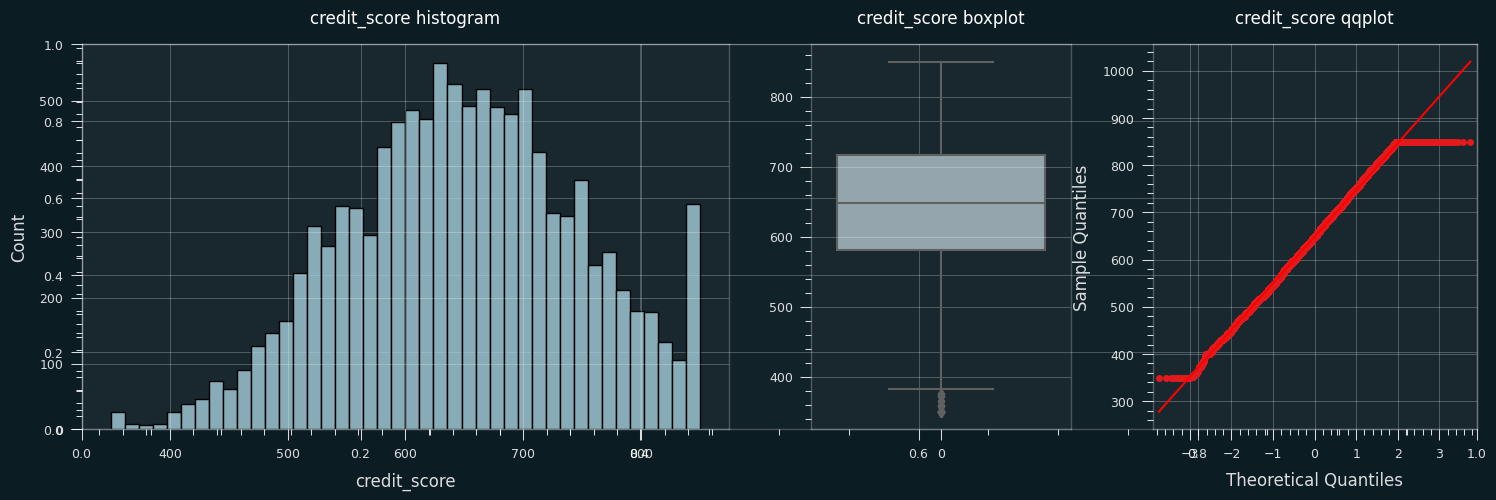

Nilai skew credit_score = -0.08048107870321128


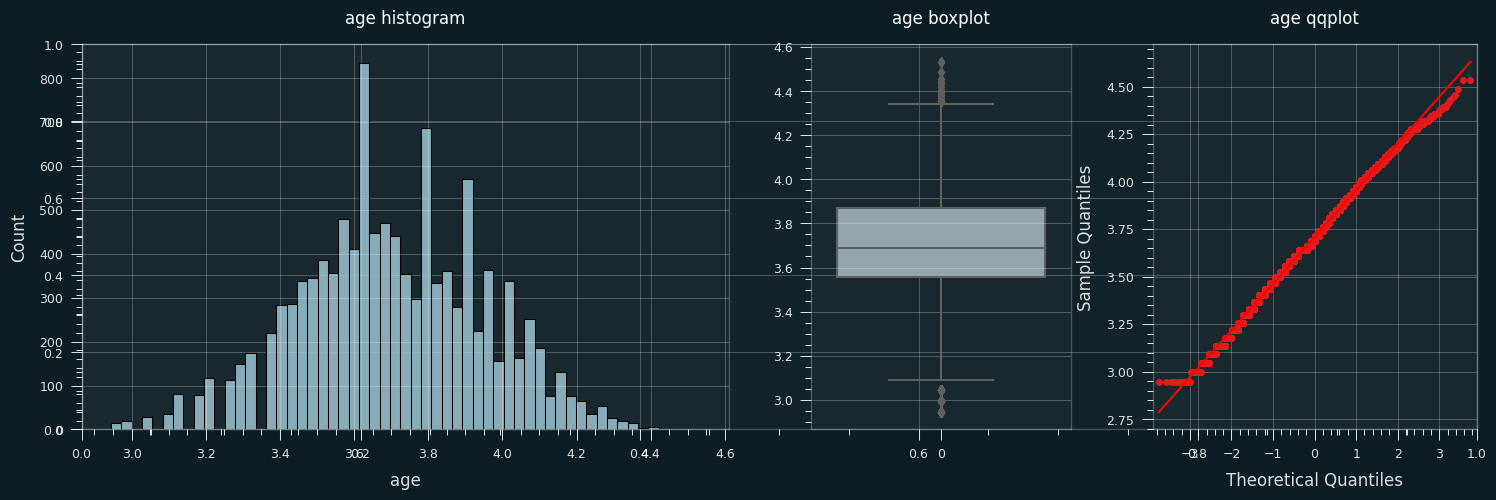

Nilai skew age = -0.06706637760758224


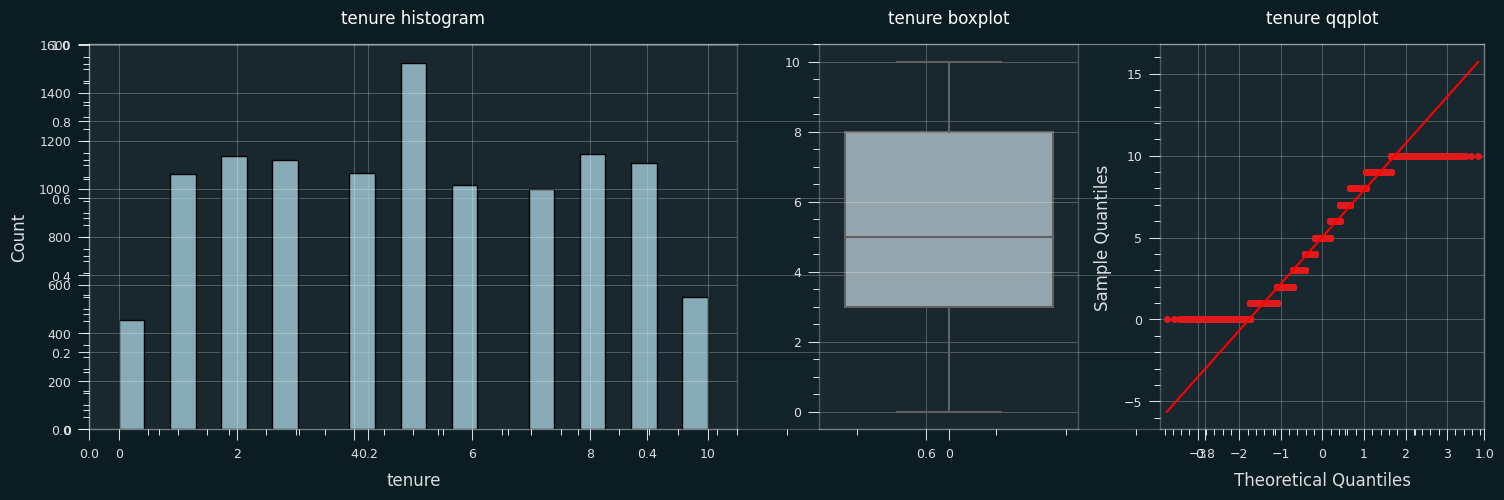

Nilai skew tenure = 0.017060553734715562


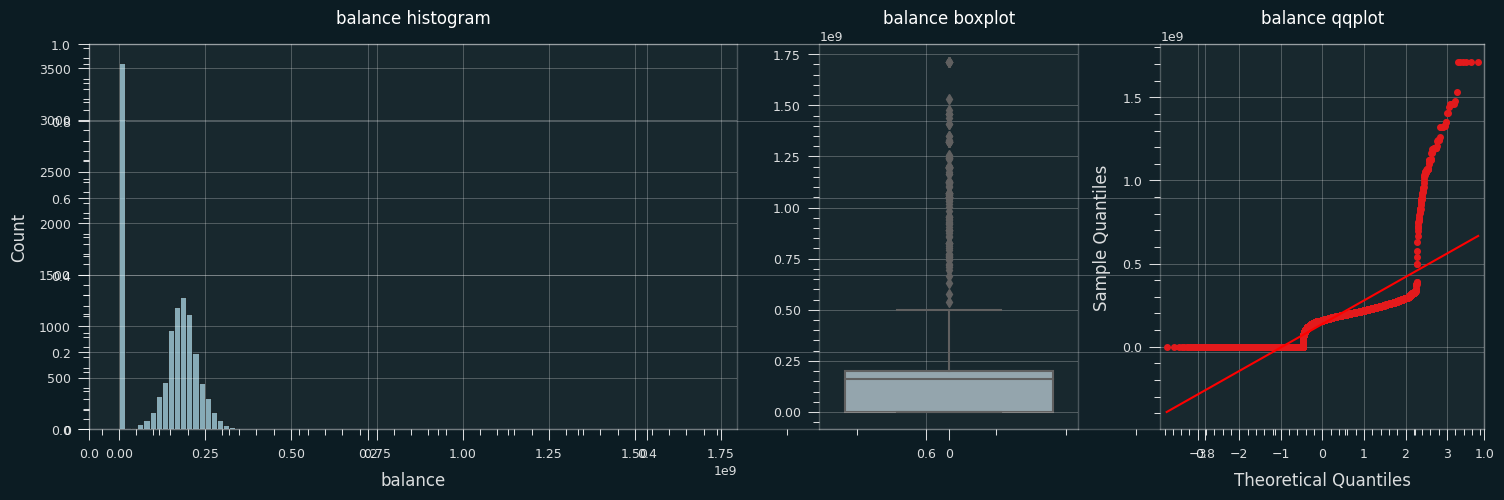

Nilai skew balance = 4.027055644454018


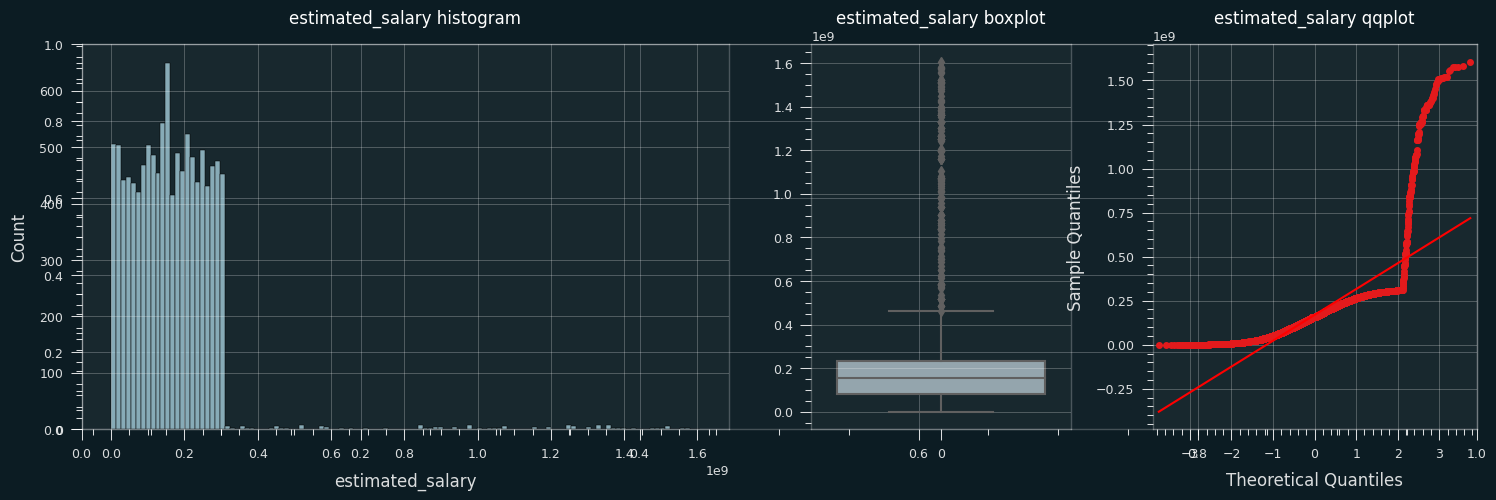

Nilai skew estimated_salary = 4.565085631892261


In [125]:
def generate_numerical_viz(data):
    for i in data[numericals]:
        non_nan_data = data[data[i].notna()]

        fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 0.8, 1]})
        
        # Histogram
        sns.histplot(non_nan_data[i], ax=axes[0], color='lightblue')
        axes[0].set_title(f"{i} histogram")
        
        # Boxplot
        sns.boxplot(non_nan_data[i], ax=axes[1], palette=palette1)
        axes[1].set_title(f"{i} boxplot")
        
        # QQplot
        qqplot(non_nan_data[i], ax=axes[2], line="s")    
        axes[2].set_title(f"{i} qqplot")
        
        plt.show()
        
        # hitung skew
        print(f"Nilai skew {i} = {skew(non_nan_data[i])}")

generate_numerical_viz(df)


Nah disini keliatan nih

* Skewness credit_score = -0.08048107870321128:

Nilai skew mendekati 0, menunjukkan distribusi data cenderung simetris. Tidak terlalu condong ke kanan atau kiri. Distribusi cenderung Normal.
* Skewness age = -0.06706637760758224:

Nilai skew mendekati 0, menunjukkan distribusi data cenderung simetris. Tidak terlalu condong ke kanan atau kiri. Distribusi cenderung Normal.
* Skewness tenure = 0.017060553734715562:

Nilai skew mendekati 0, menunjukkan distribusi data cenderung simetris. Tidak terlalu condong ke kanan atau kiri.Distribusi cenderung Normal.
* Skewness balance = 4.027055644454018:

Nilai skew positif besar, menunjukkan distribusi data condong ke kanan. Ada kemungkinan terdapat nilai yang jauh di atas rata-rata. keliatan bangett dari outlier gila-gilaannya itu.
* Skewness estimated_salary = 4.565085631892261:

Nilai skew positif besar, menunjukkan distribusi data condong ke kanan. Ada kemungkinan terdapat nilai yang jauh di atas rata-rata. bisa keliatan tuh dari outlier yang banyak banget di Q3. Nah dari sini kita bisa ngerancang gimana tuh cara ngehapus outliernya/ apakah outlier itu penting.

In [85]:
df['age'] = np.log1p(df.age)

biar age distribusinya lebih simetris, maka kita jadiin ke log.

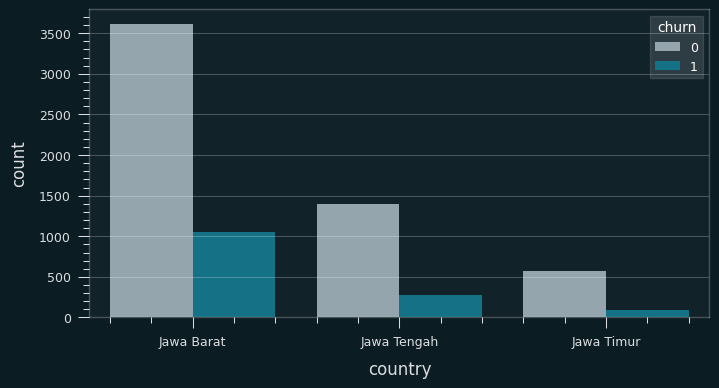

22.52% of customers from Jawa Barat has churned.
16.27% of customers from Jawa Tengah has churned.
13.21% of customers from Jawa Timur has churned.


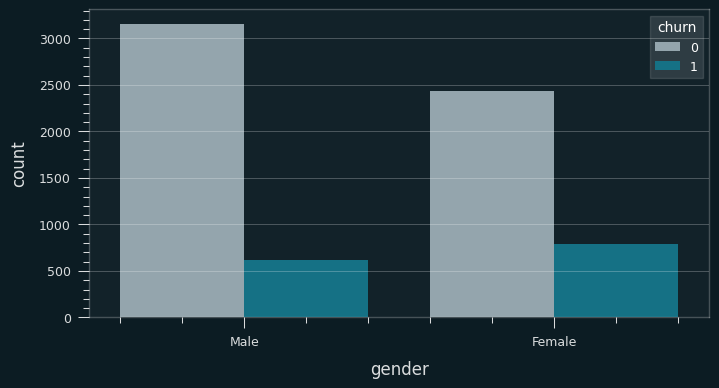

16.43% of customers who are Male has churned.
24.49% of customers who are Female has churned.


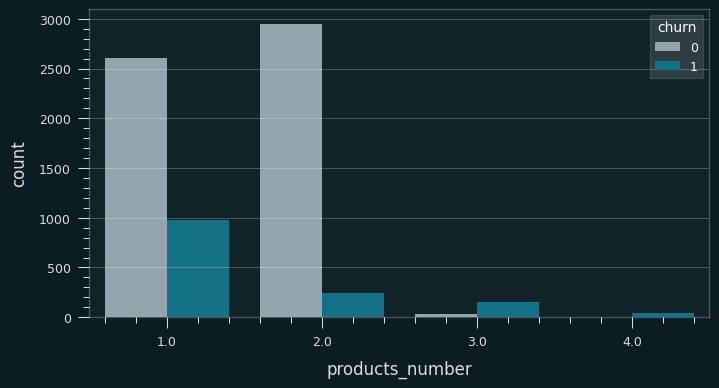

7.5% of customers who use 2.0 products_number has churned.
27.27% of customers who use 1.0 products_number has churned.
82.42% of customers who use 3.0 products_number has churned.
100.0% of customers who use 4.0 products_number has churned.


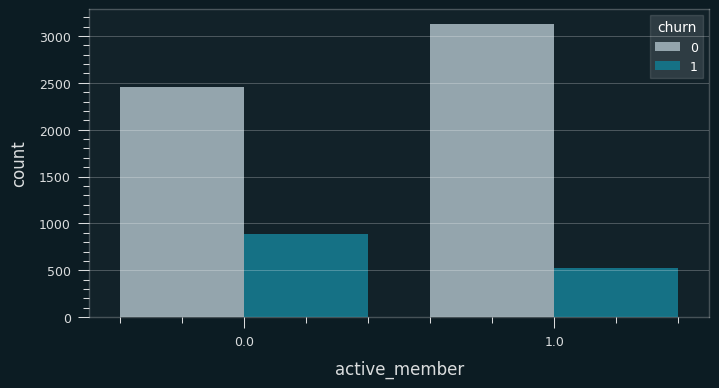

26.47% of customers who are 0.0 has churned.
14.34% of customers who are 1.0 has churned.


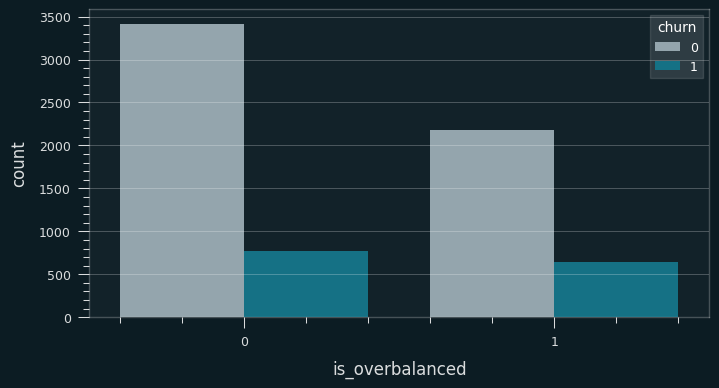

22.71% of customers who are 1 has churned.
18.42% of customers who are 0 has churned.


In [87]:
def generate_cat_viz(data):
    for i in categoricals:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=data, x=i, hue="churn", palette=palette3)
        plt.show()
        for x in data[i].unique():
            if pd.notna(x):
                churn_pcnt = len(data[(data[i] == x) & (data["churn"] == 1)]) / len(data[data[i] == x]) * 100
                churn_pcnt = round(churn_pcnt, 2)
                if i == "country":
                    print(f"{churn_pcnt}% of customers from {x} has churned.")
                elif i not in ["credit_card", "products_number"]:
                    print(f"{churn_pcnt}% of customers who are {x} has churned.")
                else:
                    print(f"{churn_pcnt}% of customers who use {x} {i} has churned.")

generate_cat_viz(df)


Ada kecenderungan tuh keliatan yang "100.0% of customers who use 4.0 products_number has churned."
yang pake products_number 4 pasti churn, so apa yang kita lakuin? bisa digunain buat handling missing value juga nih.

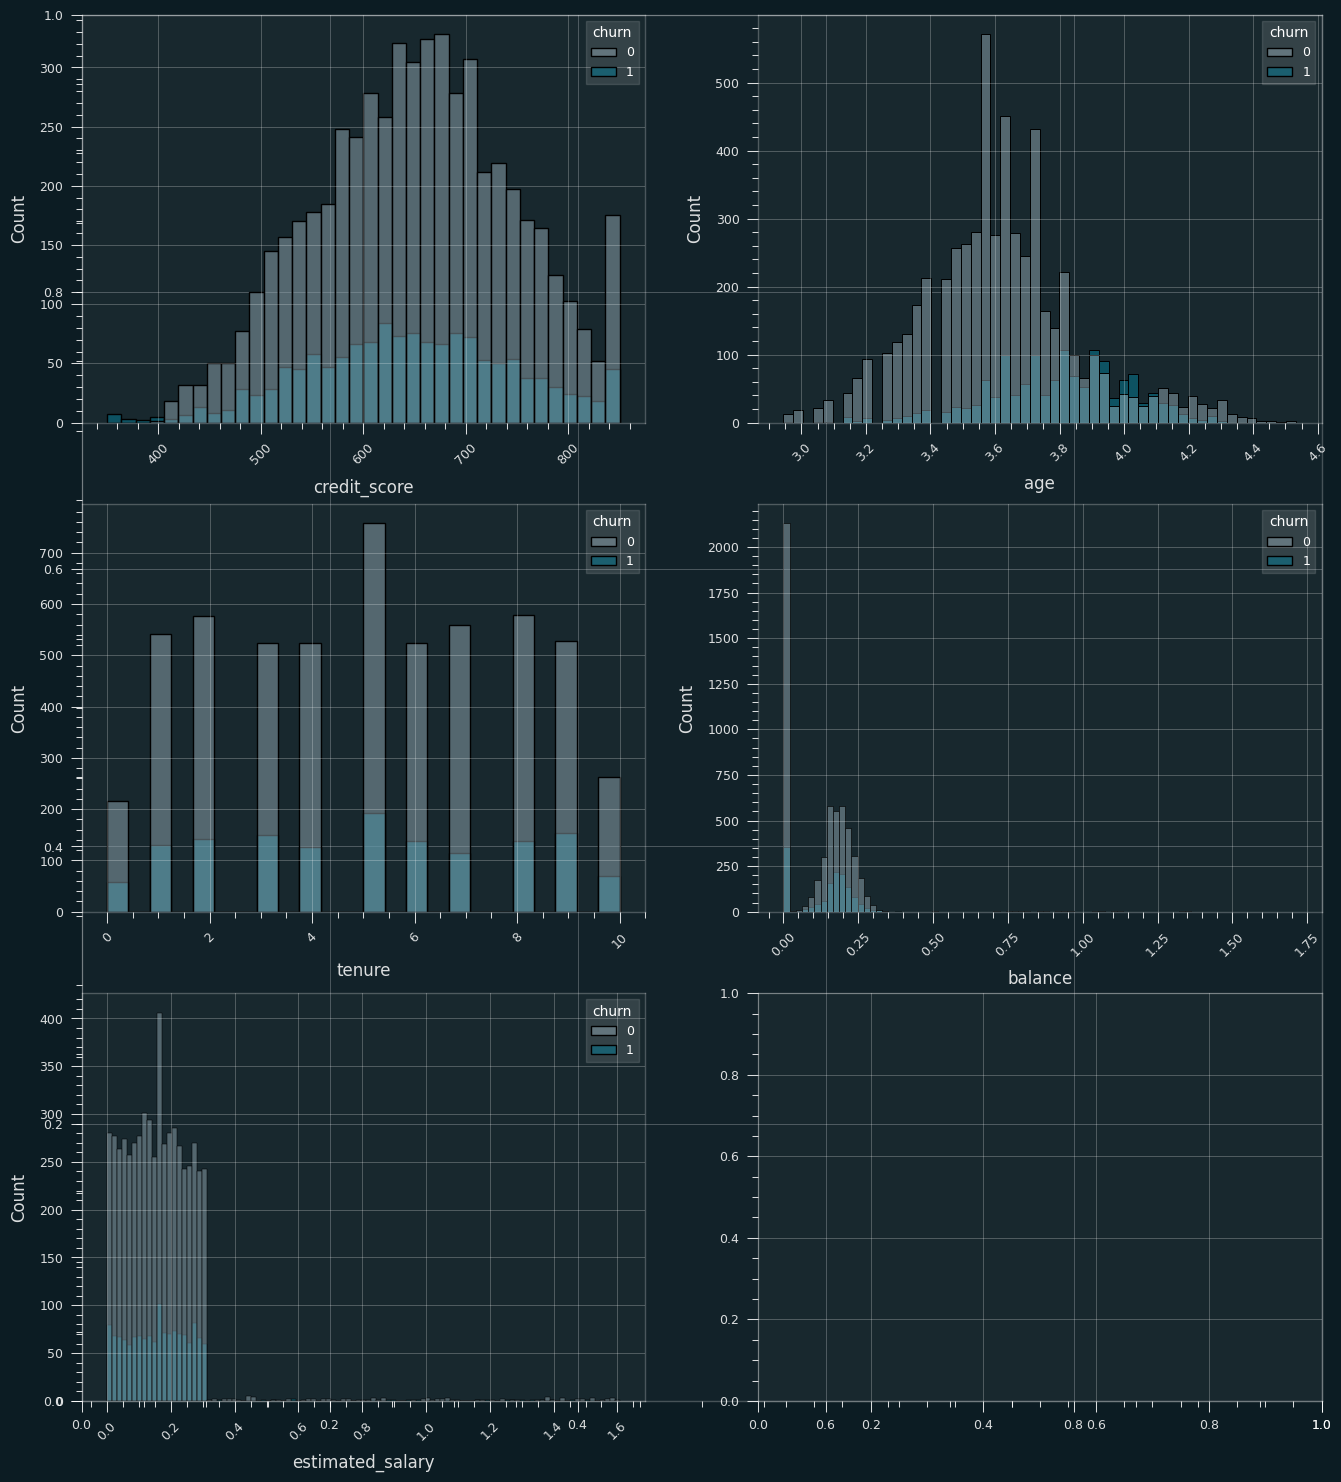

In [88]:
# Calculate the number of rows and columns for subplots
num_rows = len(numericals) // 2 + (len(numericals) % 2 > 0)
num_cols = min(len(numericals), 2)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 8, 6 * num_rows))

# Flatten the axes if necessary
if num_rows > 1:
    axes = axes.flatten()

# Iterate over numerical columns and plot histograms
for i, numerical in enumerate(numericals):
    ax = axes[i] if num_rows > 1 else axes
    sns.histplot(data=df, x=numerical, hue="churn", alpha=0.5, ax=ax,palette = palette1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()


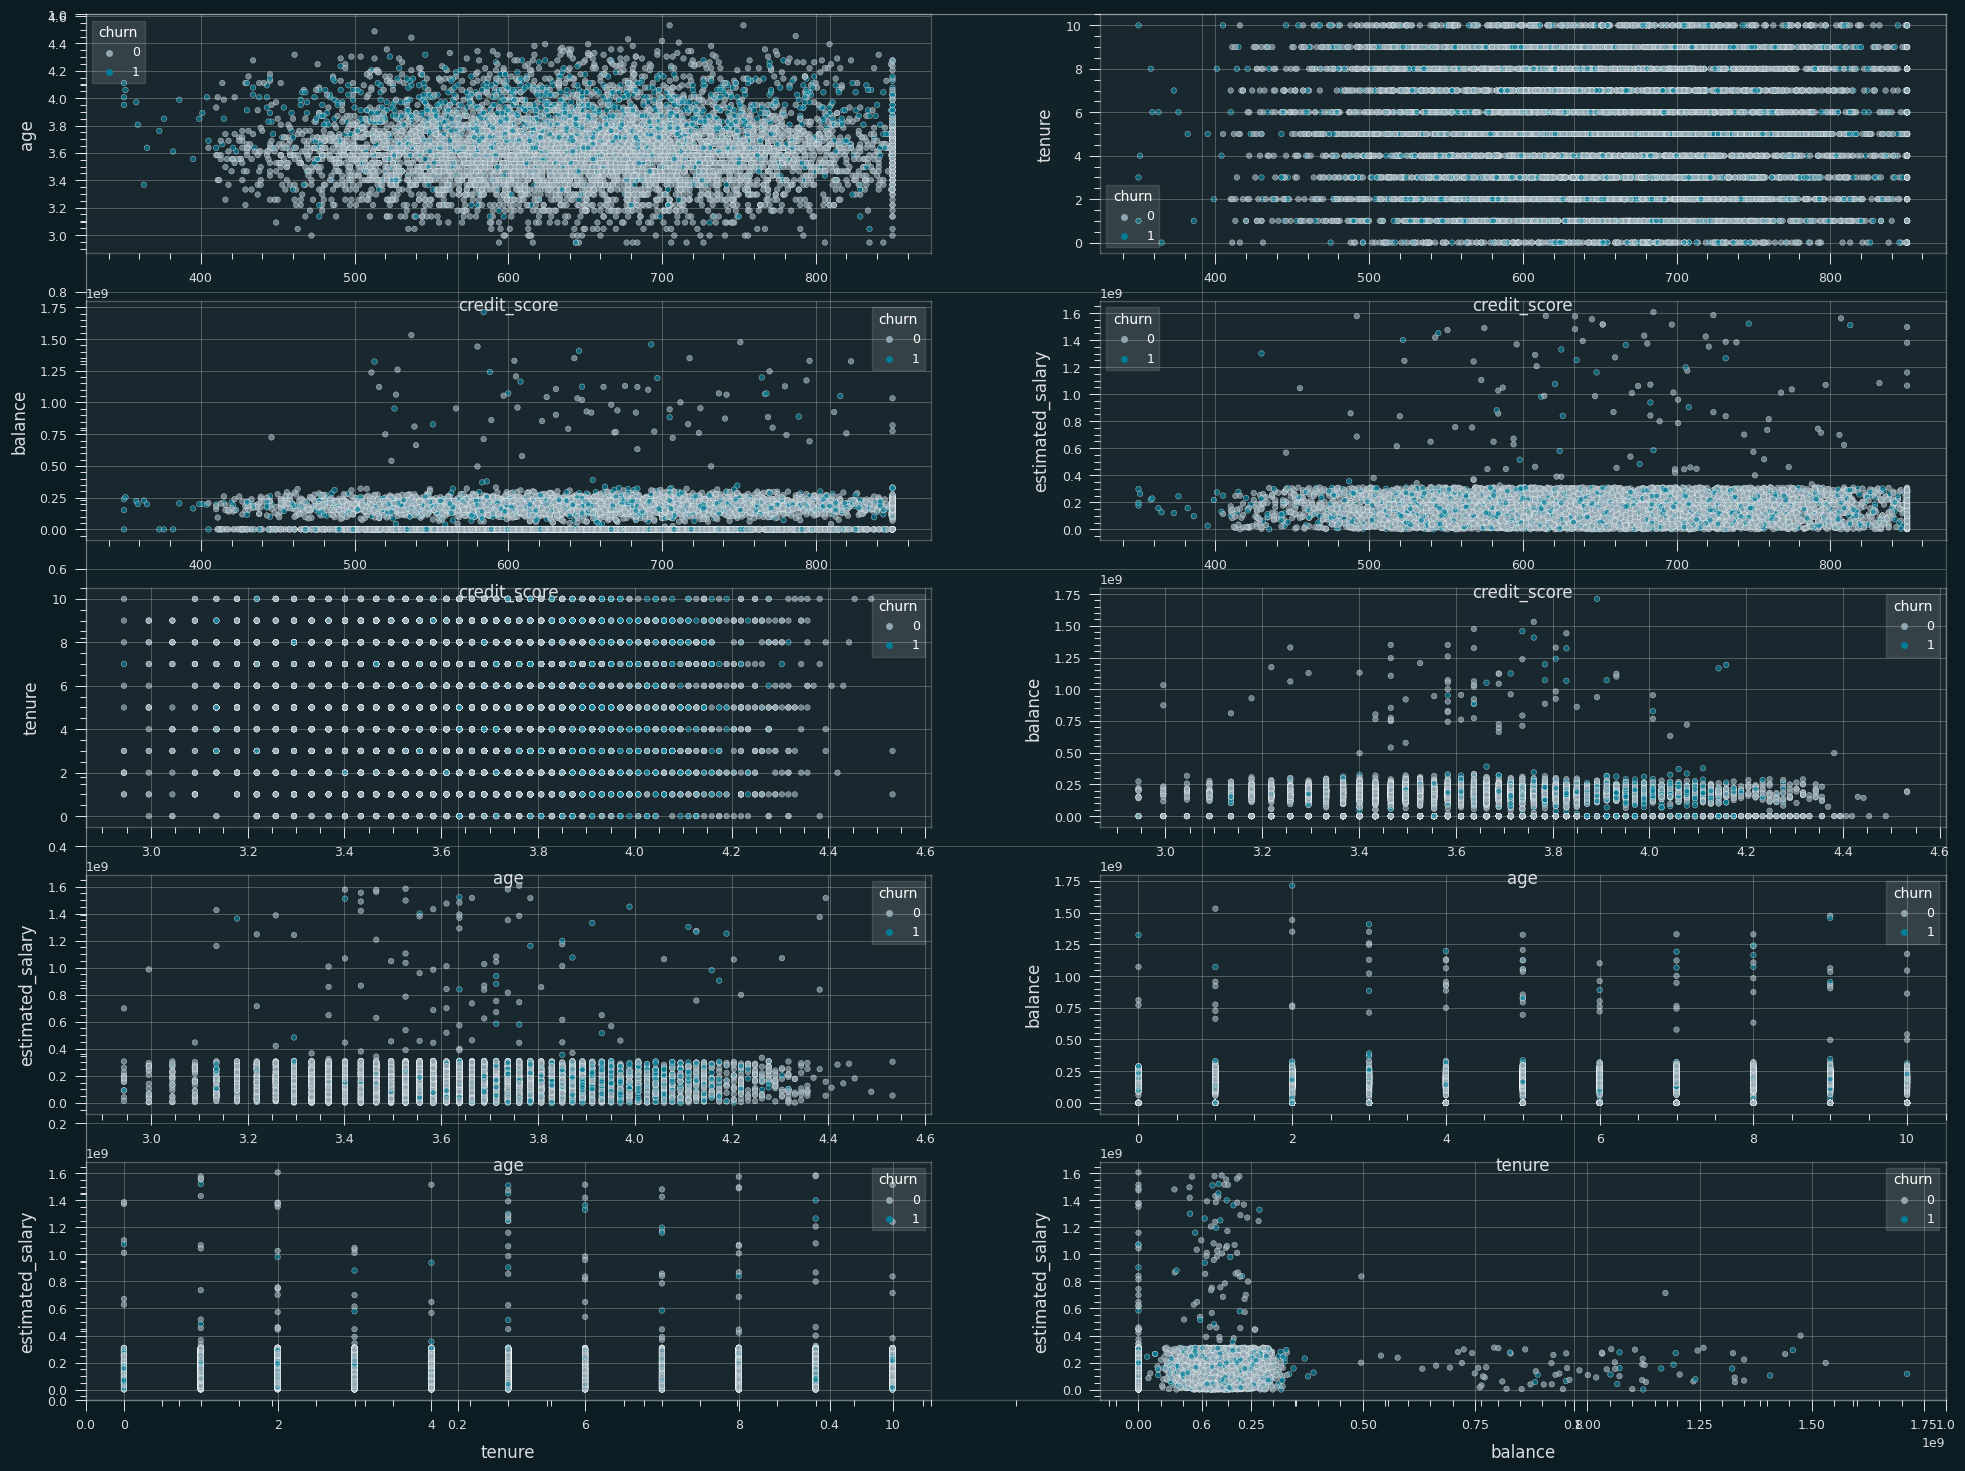

In [89]:
colors = ["g","r","y","b","orange","g","r","y","b","orange"]
fig,axes = plt.subplots(5,2,figsize = (24,18))
axes = axes.flatten()
a = 0
for i,col in enumerate(numericals):  
    for t in range(i +1 ,len(numericals)):        
        sns.scatterplot(data = df,x = numericals[i], y = numericals[t], ax = axes[a],palette = palette1,alpha = 0.7, hue = "churn")
        a = a + 1
plt.show()       

gaada korelasi antara numerikal variabel kan, jadi aman-aman aja digunain.

# Feature Selection

Nah gimanasih cara buat ngeseleksi fitur?

Bisa gunain uji chi-squared untuk ngehitung impact kolom sama kolom target. Nah impact yang relatif rendah bisa dihapus aja tuh untuk ngurangin noise.

Selain uji chi-squared. bisa juga gunain beberapa cara lain:
1. PCA
Nah, ini tu kek ngegabungin beberapa kolom jadi satu, tapi tetap nyimpen sebanyak mungkin informasi yang penting. Jadi, kita bisa pilih kolom-kolom yang penting dan buang yang ga terlalu berpengaruh. Biar ga ribet dan komputasinya ga gede.

2. Binning
Binning itu kayak cara ngelompokin nilai-nilai data jadi grup-grup. Misalnya, kalo umur, kita bisa bikin grup umur, kayak 0-10 tahun, 11-20 tahun, gitu deh. Nah, ini bisa bantu kita fokus ke informasi yang lebih besar dan ngurangin detail-detail kecil yang ga terlalu penting.

In [91]:
enc = LabelEncoder()
for c in categoricals:
    df[c] = enc.fit_transform(df[c])

features = df.loc[:,categoricals]
target = df.loc[:,'churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

In [93]:
featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']).sort_values(ascending = False,by = ["Chi Squared Score"])
featureScores

,Chi Squared Score
active_member,76.356068
country,51.070512
gender,32.374732
is_overbalanced,11.509987
products_number,9.113481


In [94]:
df.drop(columns = ["credit_card"],inplace = True)

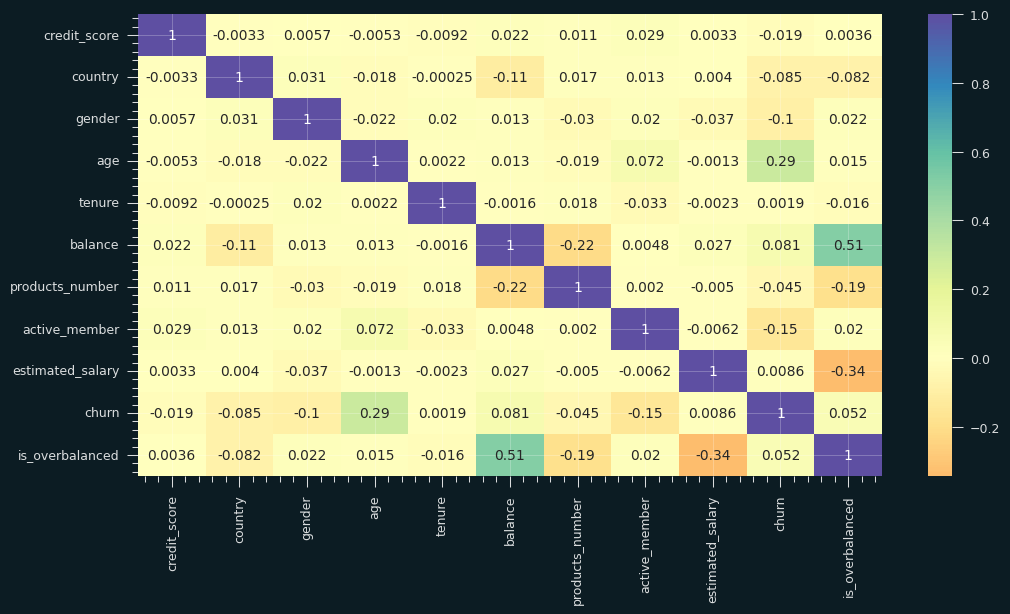

In [95]:
cor = df.corr()
plt.figure(figsize= (12,6))
sns.heatmap(cor, annot = True, fmt=".2g",cmap = 'Spectral', center = 0)
plt.show()

# Analisis VIF
Penting buat liat ada multikolineritas di variabel kita. kita gamau tuh antar variabel independen malah saling berkaitan, ato saling dependen.

Nah gini:
* VIF >2.5 biasanya consider collinearity
* VIF > 5 biasanya concern punya collinearity
* VIF >10 udah problematik udah punya problem kolinearitas yang tinggi

In [96]:
def calculate_vif(data):
    non_nan_data = data.dropna()

    pp = sm.add_constant(non_nan_data)

    vif = pd.DataFrame()
    vif['Variable'] = pp.columns
    vif['VIF'] = [variance_inflation_factor(pp.values, i) for i in range(pp.shape[1])]

    return vif

vif_result = calculate_vif(df)
vif_result

,Variable,VIF
0,const,292.031310
1,credit_score,1.002006
2,country,1.019634
3,gender,1.014043
4,age,1.112146
5,tenure,1.002349
6,balance,1.488698
7,products_number,1.062389
8,active_member,1.041966
9,estimated_salary,1.214810


# Oversampling gunain Replication

Dalam kasus kita, data kita termasuk imbalanced. liat aja churn dibanding non churn berapa. so kita perlu oversampling biar ga bias modelnya.

Kenapa penting buat gabias?

Coba baca ini niih dampak karena bias:
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

In [97]:
def oversamp(df):
    churners = df[df['churn'] == 1]
    non_churners = df[df['churn'] == 0]
    print(len(churners))
    print(len(non_churners))
    oversampled = churners.sample(len(non_churners),replace = True)
    df = pd.concat([non_churners,oversampled])
    return df

df = oversamp(df)

1410
5590


In [98]:
def Smote_oversample(data):
    data_no_nan = data.dropna()

    X = data_no_nan.drop(columns=['churn'])
    y = data_no_nan['churn']

    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(X, y)

    return X_resampled, y_resampled

X,y = Smote_oversample(df)

### holdout and kfold

mengapa holdout penting?

Holdout itu kayak misalnya, kita punya sejuta data, tapi kita simpan aja sebagian kecil buat dites modelnya. ini penting biar kita bisa lihat seberapa baik model kita performa pas dihadapkan sama data yang belum pernah dilihat sebelumnya. kayak ujian gitu, kan? biar ga cuma hafal doang, tapi bener-bener paham.

mengapa k-fold penting?

nah, K-Fold itu kayak nge-bagi-bagi data kita jadi beberapa bagian (fold). misalnya, kalo K-nya 5, berarti data dibagi jadi 5 fold. Trus, kita latih model sebanyak 5 kali, masing-masing kali pake 4 fold buat latihan dan 1 fold buat uji. ini juga penting biar model kita enggak terlalu tergantung sama satu set data aja. jadi, kayak ujiannya lebih adil gitu.

jadi, intinya holdout dan k-fold itu penting buat ngejamin kalo model kita bener-bener bisa diandalkan dan bisa berlaku bagus ga cuma buat data yang udah dia lihat sebelumnya, tapi juga buat data yang belum pernah dia temui. Biar kita lebih yakin dan bisa ngukur seberapa bagus model kita sebelum dia diaplikasikan.

In [99]:
fold = KFold(n_splits = 5, shuffle = True, random_state = 3)
x_train, x_test, y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 2)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((8944, 10), (8944,), (2236, 10), (2236,))

### Basic Modelling

# Cross Validation

Jadi, bayangin kita lagi latihan model kayak lagi belajar buat ujian. Nah, cross-validation itu kayak cara kita ngecek seberapa pintar kita sebelum ujian beneran.

Gini, kita punya dataset, kan? Cross-validation itu kayak kita bagi-bagi dataset itu jadi beberapa potongan. Misalnya, kita bagi jadi 5 potongan, ini namanya 5-fold cross-validation. Terus, kita latih model kita sebanyak 5 kali, setiap kali pakai 4 potongan buat belajar, dan 1 potongan buat diuji. Jadi, setiap potongan pernah jadi tempat latihan dan tempat ujian.

Nah, kenapa ini penting? Karena dengan cara ini, kita bisa lihat seberapa baik model kita berlaku bukan hanya untuk satu set data, tapi untuk berbagai variasi data. Jadi, kita lebih yakin kalo model kita bener-bener bisa dipercaya dan ga cuma berlaku bagus untuk satu situasi aja.

Jadi, cross-validation itu kayak ujiannya sebelum ujian beneran, kek kuislah.

In [100]:
mods = [XGBClassifier(),CatBoostClassifier(verbose= False),LGBMClassifier(verbose= -1)]
def get_cv_Scores(models):
    scores = {}
    for model in models:
        cvscore = cross_val_score(model,X,y,cv = fold,verbose = 0)
        scores[str(model)[:10]] = np.mean(cvscore)
        scores = pd.DataFrame(data=scores,index= ["Accuracy CV"])
    return scores
cv_sc =  get_cv_Scores(mods)
cv_sc

,XGBClassif,<catboost.,LGBMClassi
Accuracy CV,0.907156,0.86297,0.864669


### Prediction

In [101]:
def get_scores(models):
    prediction_results = {}
    for model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        recall = recall_score(y_pred,y_test)
        precision = precision_score(y_pred,y_test)
        accuracy = accuracy_score(y_pred,y_test)
        roc = roc_auc_score(y_pred,y_test)
        f1 = f1_score(y_pred,y_test)
        prediction_results[str(model)[:10]] = [accuracy,precision,recall,roc,f1]
    results_df = pd.DataFrame(data = prediction_results, index = ["Accuracy", "Precision", "Recall","ROC-AUC","F1"])
    return results_df

predictions = get_scores(mods)
results_f = pd.concat([cv_sc,predictions])
results_f.style.highlight_max(axis=1,color = 'lightgreen')


,XGBClassif,<catboost.,LGBMClassi
Accuracy CV,0.907156,0.862970,0.864669
Accuracy,0.906082,0.862254,0.857335
Precision,0.933213,0.863718,0.860108
Recall,0.883761,0.859066,0.853178
ROC-AUC,0.907171,0.862243,0.857331
F1,0.907814,0.861386,0.856629


In [102]:
mods = [XGBClassifier(),CatBoostClassifier(verbose= False),LGBMClassifier(verbose= -1)]
def get_cv_Scores(models):
    scores = {}
    for model in models:
        cvscore = cross_val_score(model,X,y,cv = fold,scoring='f1',verbose = 0)
        scores[str(model)[:10]] = np.mean(cvscore)
        scores = pd.DataFrame(data=scores,index= ["F1 Score CV"])
    return scores
cv_sc =  get_cv_Scores(mods)
cv_sc

,XGBClassif,<catboost.,LGBMClassi
F1 Score CV,0.910405,0.864384,0.866022


# Stacked Model

Nah mengapa bagus ngestacked model, karena kita bisa gabungin beberapa model buat dapet manfaat dari masing-masing modelnya. Kadang-kadang satu model aja kurang bisa nangkep pola dengan baik. Nah, jadi kita ambil hasil prediksi dari semua model itu, terus diambil rata-ratanya. Ini kayak kita kumpulin ide dari berbagai sumber buat hasil yang lebih kuat dan handal.

In [103]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.base import clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)
            
        return self
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        predictions = np.mean(predictions, axis=1)
        return np.where(predictions > 0.5,1,0)

# Evaluasi

In [104]:
stacked = AveragingModels(models = mods)
stacked.fit(x_train,y_train)
pred_st = stacked.predict(x_test)
recall_st = recall_score(pred_st,y_test)
precision_st = precision_score(pred_st,y_test)
accuracy_st = accuracy_score(pred_st,y_test)
roc_st = roc_auc_score(pred_st,y_test)
f1_st = f1_score(pred_st,y_test)
results_f["Stacked"] = [0,accuracy_st,precision_st,recall_st,roc_st,f1_st]
results_f.rename(columns = {"<catboost.":"CB"},inplace=True)
results_f.style.highlight_max(axis=1,color = 'lightgreen')

,XGBClassif,CB,LGBMClassi,Stacked
Accuracy CV,0.907156,0.862970,0.864669,0.000000
Accuracy,0.906082,0.862254,0.857335,0.875671
Precision,0.933213,0.863718,0.860108,0.877256
Recall,0.883761,0.859066,0.853178,0.872531
ROC-AUC,0.907171,0.862243,0.857331,0.875660
F1,0.907814,0.861386,0.856629,0.874887


Karena disini keliatannya XGB lebih powerful, jadi ayo kita pake XGB.

## Evaluasi Akhir

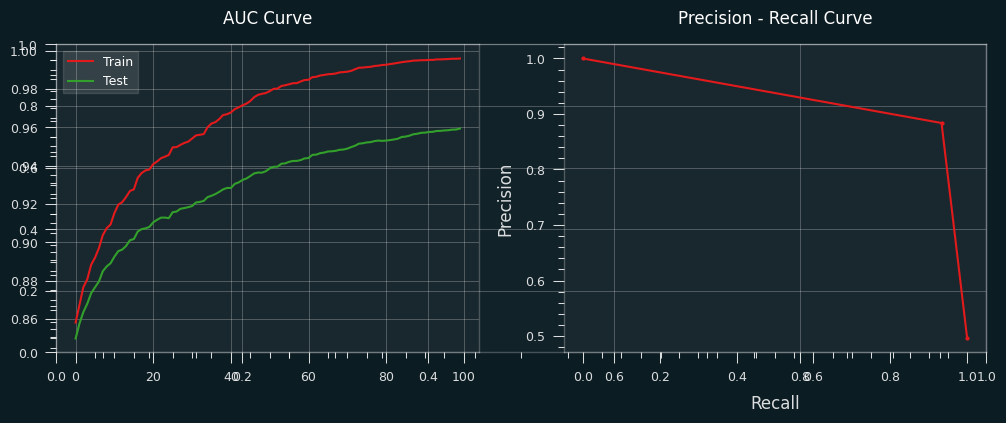

In [105]:

evals = [(x_train, y_train), (x_test, y_test)]
eval_metrics = ['auc', 'error']

model1 = XGBClassifier()
model1.fit(x_train, y_train, eval_set=evals, eval_metric=eval_metrics, verbose=False)
xgb_pred = model1.predict(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, xgb_pred)
# Get the evaluation results
results = model1.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title("AUC Curve") 
# Plot the recall curve
ax[1].plot(recall, precision, marker='.')
ax[1].set_title("Precision - Recall Curve") 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Ngesubmit

In [107]:
submit=pd.read_csv('/kaggle/input/ccp-challange/test.csv')

In [116]:
submit['is_overbalanced'] = (submit.estimated_salary - submit.balance).apply(lambda x: 0 if x >= 0 else 1)

In [118]:
submit=submit.drop(['customer_id'], axis=1)
submit=submit.drop(['credit_card'], axis=1)

In [ ]:
categoricals,numericals = split_cats_nums(submit)

In [ ]:
submit['age'] = np.log1p(submit.age)

In [ ]:
enc = LabelEncoder()
for c in categoricals:
    submit[c] = enc.fit_transform(submit[c])

In [121]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      3000 non-null   int64  
 1   country           3000 non-null   int64  
 2   gender            3000 non-null   int64  
 3   age               3000 non-null   float64
 4   tenure            3000 non-null   int64  
 5   balance           3000 non-null   float64
 6   products_number   3000 non-null   int64  
 7   active_member     3000 non-null   int64  
 8   estimated_salary  3000 non-null   float64
 9   is_overbalanced   3000 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 234.5 KB


In [122]:
xgb_pred1 = model1.predict(submit)

In [124]:
submission=pd.read_csv('/kaggle/input/ccp-challange/sample_submission.csv')
submission.drop('churn', axis=1)
submission['churn']=xgb_pred1
submission.to_csv('submit10.csv', index=False)